## 0. Librerias

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

import sys
import os

!pip install pandas
import pandas as pd

!pip install nltk
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración

from collections import Counter

## 1. Carga y lectura de datos

Cargamos desde la función utils el dataset y hacemos una pequeña exploración del corpus para ver un poco la estructura del contenido, el tamaño y el balanceo de reviews.

In [2]:
from utils import load_beauty_reviews

#### El fichero de datos `All_Beauty.jsonl` no se ha commiteado pero se ha descargado en local de: https://amazon-reviews-2023.github.io/#for-user-reviews

In [ ]:
# Path al directorio donde tenemos los datasets con las reviews
datasets_path = 'Inputs/data'
corpus_beauty_folder = 'All_Beauty.jsonl'

In [4]:
reviews_dict = load_beauty_reviews(datasets_path, corpus_beauty_folder)

In [5]:
print(len(reviews_dict))

701528


In [6]:
print(reviews_dict.get(180))

{'rating': 5.0, 'title': 'Amazing item.', 'text': 'Very well made,good quality and very good color.', 'images': [], 'asin': 'B073SBNLJJ', 'parent_asin': 'B073SBNLJJ', 'user_id': 'AHL5ZHN64UHJOGQLPINJ3BN4VBPA', 'timestamp': 1559566443959, 'helpful_vote': 3, 'verified_purchase': True}


#### En este ejemplo vemos que el titulo indica connotación positiva. Más adelante concatenaremos `title`y `text` para tener más contexto e informacioón para el analisis

In [7]:
# Extraer todos los ratings
ratings = [review['rating'] for review in reviews_dict.values()]

# Calcular min y max para saber escala de valoraciones
print(f"Rating mínimo: {min(ratings)}")
print(f"Rating máximo: {max(ratings)}")

Rating mínimo: 1.0
Rating máximo: 5.0


In [8]:
# Calcular porcentaje de cada valor de rating
rating_counts = Counter(ratings)
total = len(ratings)

print("Distribución de ratings:\n")
for rating in sorted(rating_counts.keys()):
    count = rating_counts[rating]
    percentage = (count / total) * 100
    print(f"Rating {rating}: {count:,} reviews ({percentage:.2f}%)")

Distribución de ratings:

Rating 1.0: 102,080 reviews (14.55%)
Rating 2.0: 43,034 reviews (6.13%)
Rating 3.0: 56,307 reviews (8.03%)
Rating 4.0: 79,381 reviews (11.32%)
Rating 5.0: 420,726 reviews (59.97%)


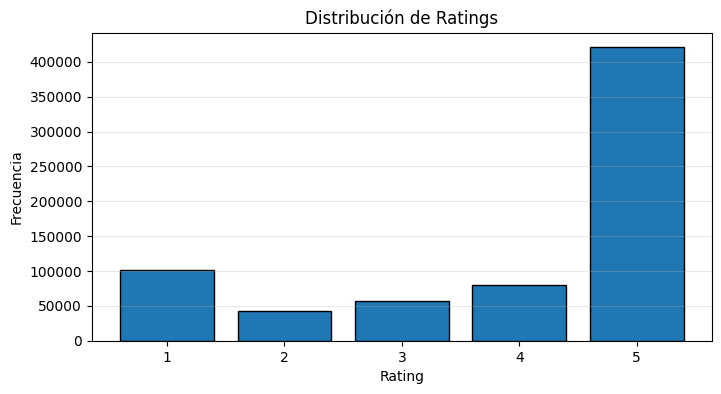

In [9]:
# Crear histograma de ratings
plt.figure(figsize=(8, 4))
plt.hist(ratings, bins=range(1, 7), edgecolor='black', align='left', rwidth=0.8)
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de Ratings')
plt.xticks(range(1, 6))
plt.grid(axis='y', alpha=0.3)
plt.show()

### 1.1 Reequilibro el dataset para facilitar el estudio de la práctica

#### El corpus esta muy desbalanceado. Me quedo con un total de 6000 reviews equidistribuidas en positivo (3,4,5) y negativo (1,2). Lo hago para facilitar el entrenamiento posterior de los modelos desde el punto de vista didactico. 

In [10]:
# Filtrar 3000 reviews negativas (ratings 1,2) y 3000 positivas (ratings 3,4,5)
from collections import defaultdict
import random

# Agrupar reviews por rating
reviews_by_rating = defaultdict(list)
for idx, review in reviews_dict.items():
    rating = review['rating']
    reviews_by_rating[rating].append((idx, review))

# Separar en dos grupos: negativas y positivas (alineado con la función de etiquetado)
negative_reviews = []
positive_reviews = []

for rating in reviews_by_rating.keys():
    if rating <= 2:  # Ratings 1 y 2 → Label 1 (Negativo)
        negative_reviews.extend(reviews_by_rating[rating])
    else:  # Ratings 3, 4 y 5 → Label 0 (Positivo)
        positive_reviews.extend(reviews_by_rating[rating])

# Seleccionar aleatoriamente 3000 de cada grupo
random.shuffle(negative_reviews)
random.shuffle(positive_reviews)

selected_negative = negative_reviews[:3000]
selected_positive = positive_reviews[:3000]

# Combinar y mezclar
all_selected = selected_negative + selected_positive
random.shuffle(all_selected)

# Crear nuevo diccionario con índices consecutivos
balanced_reviews = {}
for new_idx, (old_idx, review) in enumerate(all_selected):
    balanced_reviews[new_idx] = review

# Reemplazar el diccionario original
reviews_dict = balanced_reviews
print(f"Total de reviews seleccionadas: {len(reviews_dict)}")
print(f"  - Negativas (≤2): {len(selected_negative)}")
print(f"  - Positivas (≥3): {len(selected_positive)}")

Total de reviews seleccionadas: 6000
  - Negativas (≤2): 3000
  - Positivas (≥3): 3000


Concateno `title`y `text`

In [11]:
reviews_text = []
reviews_rating = []

for review in reviews_dict.values():
    reviews_text.append(f"{review.get('title', '')} {review.get('text', '')}".strip())
    reviews_rating.append(review.get('rating'))

df = pd.DataFrame({
    'review': reviews_text,
    'rating': reviews_rating
})
df.dropna(subset=['review', 'rating'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
df.head()

,review,rating
0,Sculpting Crean Use this product and find that...,5.0
1,Keep your money Foe the price one expects more...,1.0
2,Fell apart after a year Was good while it last...,1.0
3,Five Stars Works beautifully. Great for my cli...,5.0
4,Worst Product I recently purchased this produc...,1.0


### 1.2 Guardo DataFrame para uso en otros notebooks

In [14]:
# Guardar el DataFrame simplificado
import os
os.makedirs('Outputs/data', exist_ok=True)
df.to_pickle('Outputs/data/df_beauty_balanced.pkl')
print(f"DataFrame guardado: {len(df)} reviews")

DataFrame guardado: 6000 reviews


### 1.3 Convierto el corpus a minusculas y separo por palabras

In [140]:
splitted_reviews = df['review'].str.lower().str.split()

In [141]:
splitted_reviews

0       [nice,, wrong, color, loved, the, braid,, but,...
1       [it, does, nothing., i, have, terrible, eye, b...
2       [these, do, not, fit., this, are, hard, to, pu...
3       [fix, this, only, about, 50%, usable., dried, ...
4       [keep, your, coins, where, do, i, start, ok, f...
                              ...                        
5995    [meh..., i, like, that, you, get, the, bleach,...
5996    [amazing, buy, wow!, this, works, exactly, as,...
5997                                  [hawaii, love, it.]
5998    [works, well, on, beards, and, hair, had, them...
5999    [good, quality, hair, the, hair, is, good, qua...
Name: review, Length: 6000, dtype: object

In [142]:
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

### 1.4 Cardinalidad del vocabulario:
Cuento el número de tokens(palabras en este caso) que componen el vocabulario y cuales son los que más aparecen

In [143]:
vocabulary_ = Counter(words)
len(vocabulary_)

17807

In [144]:
vocabulary_.most_common(10)

[('the', 8578),
 ('i', 7112),
 ('and', 5727),
 ('it', 5314),
 ('a', 4692),
 ('to', 4656),
 ('this', 3288),
 ('not', 3064),
 ('my', 2951),
 ('is', 2942)]

Son palabras que no estan aportando para un análisis de sentimiento y por tanto podría eliminarlas ocn un stopwords

### 1.5 Extracción de N-grams más frecuentes:


In [67]:
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

In [68]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [69]:
bigrams_freq_.most_common(10)

[(('i', 'have'), 618),
 (('of', 'the'), 522),
 (('it', 'is'), 463),
 (('in', 'the'), 444),
 (('it', 'was'), 410),
 (('i', 'was'), 405),
 (('and', 'i'), 404),
 (('this', 'is'), 403),
 (('this', 'product'), 387),
 (('my', 'hair'), 365)]

In [70]:
trigrams_freq_.most_common(10)

[(('a', 'lot', 'of'), 104),
 (('this', 'is', 'a'), 92),
 (('i', 'love', 'the'), 79),
 (('i', 'had', 'to'), 78),
 (('i', 'bought', 'this'), 77),
 (('i', 'love', 'this'), 72),
 (('out', 'of', 'the'), 70),
 (('waste', 'of', 'money'), 64),
 (('the', 'hair', 'is'), 63),
 (('for', 'the', 'price'), 62)]

In [71]:
bg_freq_most_common = bigrams_freq_.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = trigrams_freq_.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

In [72]:
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

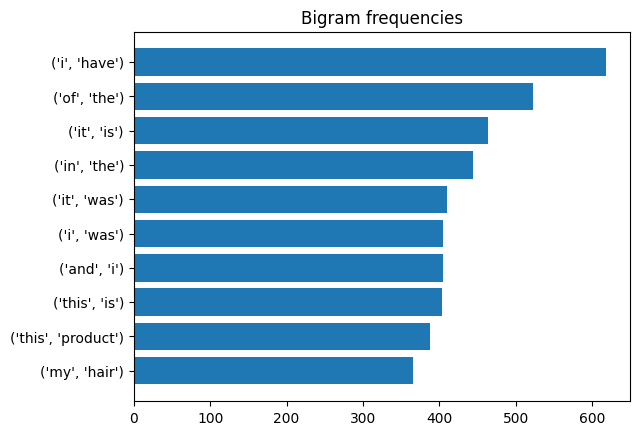

In [73]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

Los bigramas como (of the, in the, and the): Son comunes pero poco informativos para sentimiento. También incluyen pronombres que hablan de la experiencia del cliente y descriptivos (Del producto). Capturan contexto y podrían ser tenidos en cuenta en la vectorización.

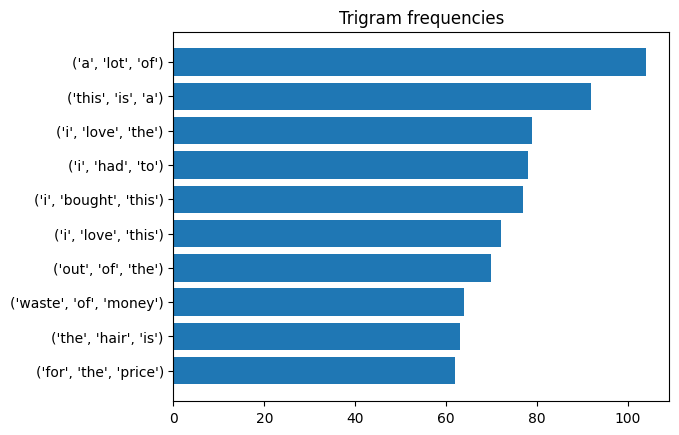

In [74]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

Vemos que para los 3-grams hay combinaciones que si son importantes, ('i', 'love', 'the'), ('i', 'love', 'this') tiene un sentimiento positivo claro. Al igual que ('waste, 'of', 'money') la tiene negativa. Capturan contexto y deberían ser tenidos en cuenta en la vectorización. 

### 1.6 Nube de palabras:


Esta visualización nos ayuda a identificar rápidamente:
- Términos más comunes en el vocabulario de belleza
- Diferencias en el lenguaje usado en reviews positivas vs negativas
- Palabras clave que caracterizan cada tipo de sentimiento

In [75]:
!pip install wordcloud
from wordcloud import WordCloud

In [76]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

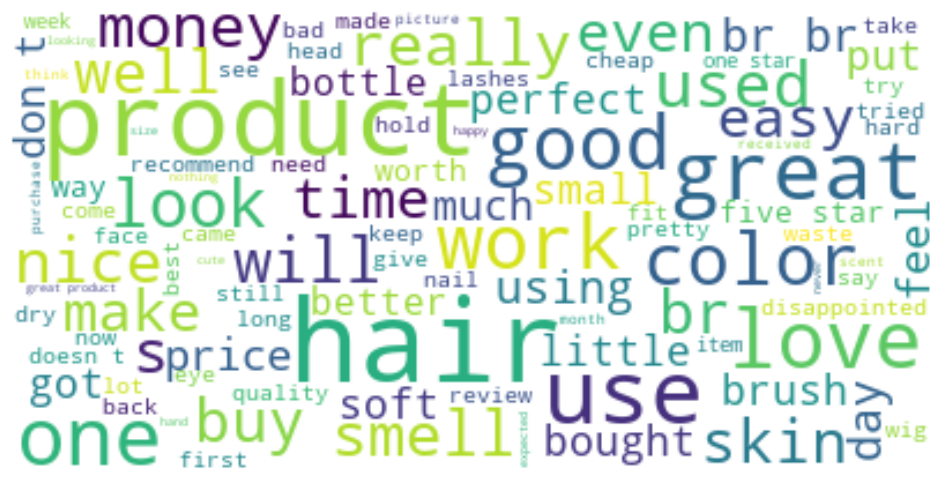

In [77]:
plot_word_cloud(words)

####
- El dataset es coherente con productos de belleza. 
- Hay bastante vocabulario emocional presente (love, great , good) en reviews positivas y, sine mbargo, más términos de experiencia de uso y descriptivos de producto para las negativas. Esto justifica mantener palabras emocionales en el preprocesado. Los bigramas serán importantes para capturar negaciones. 
- La palabra `<br, />`se repite mucho por lo que sería interesante aplicar BeautifulSoup en el preprocesado para eliminar cualquier tipo de etiqueta HTLM

### 1.7 Entrenamiento de embeddings Word2Vec

- Representa cada palabra como un vector de números (embeddings) captura relación semántica. Usaremos posteriormente para el modelo de ML

Parámetros del modelo:
- **vector_size**: 100 - dataset pequeño de 6000 reviews
- **sg**: Algoritmo 0=CBOW

In [81]:
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True) 

True

In [82]:
df.head()

,review,rating
0,A bit thin and liquidy I bought this thinking ...,3.0
1,Very thin. Not worth the price Awful. Way too ...,1.0
2,Just not good at all I'd been using a Norelco ...,2.0
3,Hair ok Hair was ok. Probably wouldn't buy it ...,3.0
4,not have a date of expiración . It’s not have ...,1.0


In [ ]:
sentences = []
for text in df['review'].astype(str):
    # Tokenizar y convertir a minúsculas
    tokens = word_tokenize(text.lower())
    # Filtrar solo palabras alfabéticas
    tokens = [token for token in tokens if token.isalpha()]
    if len(tokens) > 0:  # Solo agregar si hay tokens
        sentences.append(tokens)

print(f"Total de reviews: {len(sentences):,}")
print(f"Ejemplo de tokens: {sentences[0][:10]}...")

Total de reviews procesadas: 5,996
Ejemplo de tokens: ['a', 'bit', 'thin', 'and', 'liquidy', 'i', 'bought', 'this', 'thinking', 'that']...


In [85]:
# Entrenar modelo Word2Vec
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,      
    window=5,             
    min_count=5,          
    workers=4,           
    sg=0,                 
    epochs=10             
)

print(f"Vocabulario: {len(w2v_model.wv)} palabras")

Vocabulario: 2761 palabras


In [ ]:
# Guardar modelo para reutilización
model_path = 'outputs/models/word2vec_beauty_reviews.model'
w2v_model.save(model_path)
print(f"Modelo guardado en: {model_path}")

Modelo guardado en: outputs/word2vec_beauty_reviews.model


#### Probamos el modelo con algunas palabras para ver sus similares:

In [89]:
test_words = ['love', 'great', 'product', 'smell']

for word in test_words:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=5)
        print(f"\n   '{word}' → similares:")
        for similar_word, score in similar:
            print(f"      - {similar_word}: {score:.3f}")
    else:
        print(f"\n   '{word}' → no está en el vocabulario")



   'love' → similares:
      - absolutely: 0.799
      - loved: 0.777
      - amazing: 0.737
      - awesome: 0.726
      - gorgeous: 0.647

   'great' → similares:
      - good: 0.750
      - excellent: 0.742
      - perfect: 0.739
      - amazing: 0.720
      - decent: 0.677

   'product' → similares:
      - stuff: 0.754
      - seller: 0.734
      - item: 0.712
      - company: 0.702
      - cream: 0.681

   'smell' → similares:
      - nothing: 0.733
      - scent: 0.727
      - fragrance: 0.700
      - stuff: 0.686
      - taste: 0.684


### 1.8 Visualización 2D de embeddings con t-SNE


- Reducción de dimensionalidad para visualizar embeddings de alta dimensión en 2D.

Parámetros de t-SNE:
- **perplexity=15**: Balance entre estructura local y global
- **n_iter=3500**: Iteraciones para convergencia
- **n_components=2**: Reducir a 2d

In [90]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

Creamos claves de palabras similares basandonos en lo detectado por ej. en el `1.5 Nube de palabras`

In [113]:
keys = ['love', 'waste', 'smell', 'hair', 'product']

In [114]:
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [115]:
print(word_clusters)

[['absolutely', 'loved', 'amazing', 'awesome', 'gorgeous', 'liked', 'loves', 'stuff', 'likes', 'best'], ['save', 'waist', 'total', 'spend', 'wasted', 'spent', 'complete', 'earned', 'money', 'crap'], ['nothing', 'scent', 'fragrance', 'stuff', 'taste', 'smells', 'looks', 'however', 'vibration', 'feel'], ['scalp', 'lips', 'curly', 'felt', 'wavy', 'curls', 'head', 'feel', 'fine', 'eyes'], ['stuff', 'seller', 'item', 'company', 'cream', 'thing', 'idea', 'mascara', 'kit', 'everyone']]


In [116]:
print(f"Total de clusters: {len(embedding_clusters)}")

Total de clusters: 5


Preparamos datos para t-SNE

In [117]:
# Aplanar embeddings para t-SNE
embedding_clusters_array = np.array(embedding_clusters)
n_words_per_cluster = embedding_clusters_array.shape[1]
embedding_dim = embedding_clusters_array.shape[2]

print(f"Palabras por cluster: {n_words_per_cluster}")
print(f"Dimensión de embeddings: {embedding_dim}")

Palabras por cluster: 10
Dimensión de embeddings: 100


In [118]:
# Reshape: (n_clusters, n_words, embedding_dim) -> (n_clusters * n_words, embedding_dim)
embeddings_flat = embedding_clusters_array.reshape(
    len(embedding_clusters) * n_words_per_cluster, 
    embedding_dim
)
print(f"Dimension para t-SNE: {embeddings_flat.shape}")

Dimension para t-SNE: (50, 100)


In [119]:
tsne_model_2d = TSNE(n_components=2,perplexity=15,init='pca',max_iter=3500,random_state=32,verbose=0)

In [120]:
embeddings_2d = tsne_model_2d.fit_transform(embeddings_flat)

In [121]:
# Reshape de vuelta: (n_clusters * n_words, 2) -> (n_clusters, n_words, 2)
embeddings_2d_clustered = embeddings_2d.reshape(len(embedding_clusters), n_words_per_cluster, 2)

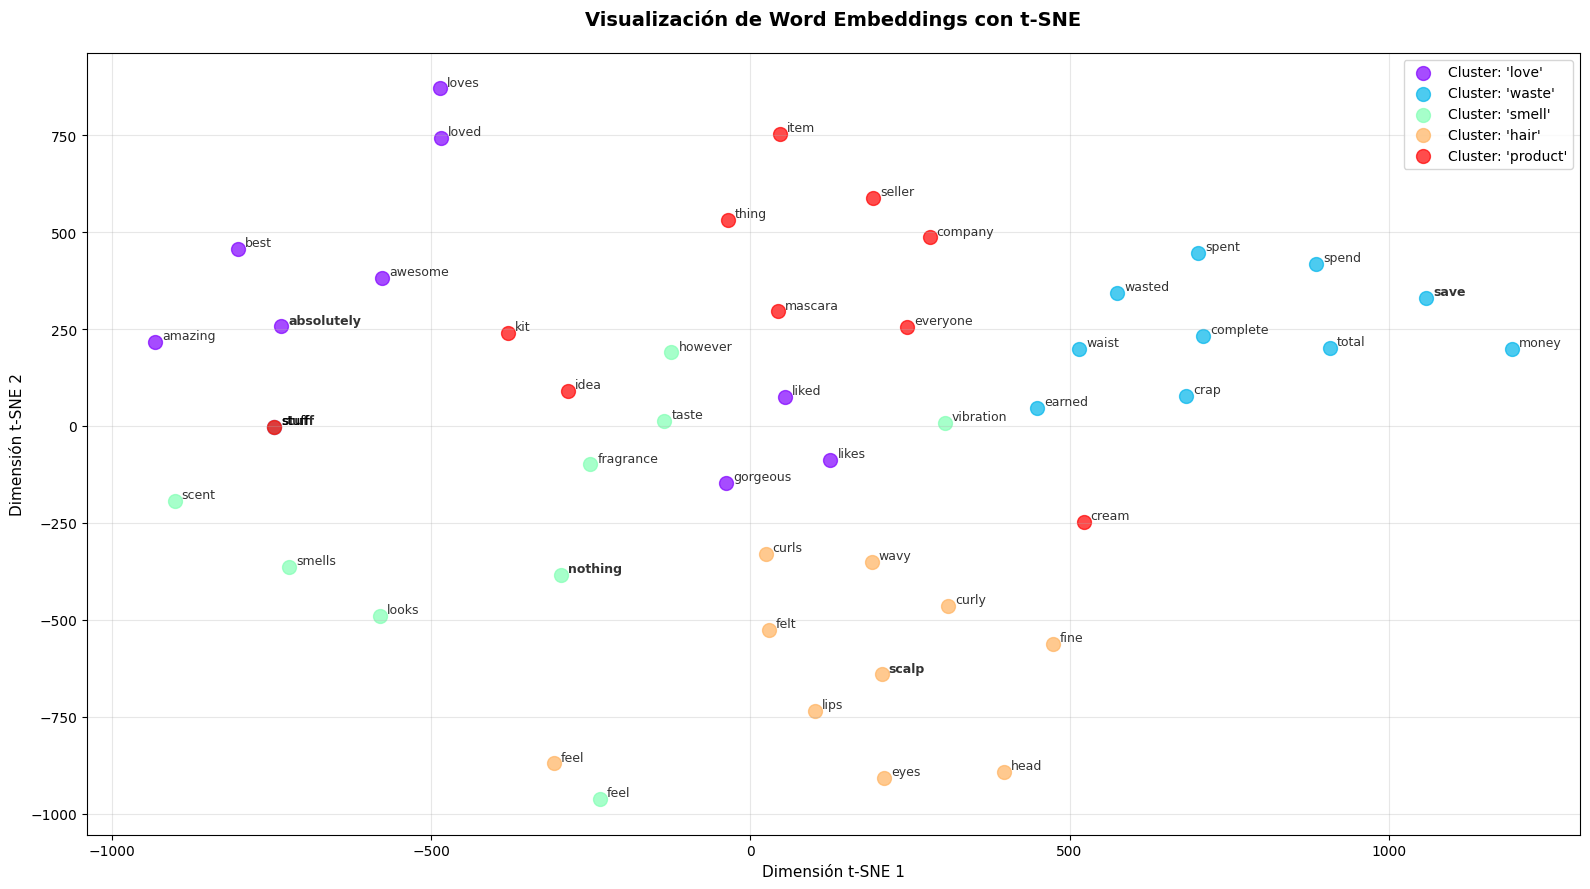

In [123]:
# Visualizar
fig, ax = plt.subplots(figsize=(16, 9))

# Colores para cada cluster
colors = plt.cm.rainbow(np.linspace(0, 1, len(embedding_clusters)))

# Plotear cada cluster
for idx, (word_cluster, embedding_cluster, color) in enumerate(
    zip(word_clusters, embeddings_2d_clustered, colors)
):
    # Extraer coordenadas x, y
    x_coords = embedding_cluster[:, 0]
    y_coords = embedding_cluster[:, 1]
    
    # Plotear puntos
    ax.scatter(
        x_coords, 
        y_coords, 
        c=[color], 
        alpha=0.7, 
        s=100,
        label=f"Cluster: '{keys[idx]}'"
    )
    
    # Agregar etiquetas de texto
    for i, word in enumerate(word_cluster):
        ax.annotate(
            word,
            xy=(x_coords[i], y_coords[i]),
            xytext=(5, 2),
            textcoords='offset points',
            fontsize=9,
            alpha=0.8,
            weight='bold' if i == 0 else 'normal'  # Palabra semilla en negrita
        )

ax.set_title('Visualización de Word Embeddings con t-SNE', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Dimensión t-SNE 1', fontsize=11)
ax.set_ylabel('Dimensión t-SNE 2', fontsize=11)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Clusters identificados:

- MORADO `love`: fuertes predictores de sentimiento positivo
- AZUL `waste`: fuerte predictor de sentiemitno negativo (Desperdicio)
- VERDE `smell`, NARANJA `hair`, ROJO `product`: ambiguos, neutros o necesitan contexto

En base a esto, considerar usar bigramas/trigramas para el modelo para palabras ambiguas.